In [17]:
import json
import re
import numpy as np
import cv2
# darkflow expect each image comes with one annotation file in the format of 
# [category number] [object center in X] [object center in Y] [object width in X] [object width in Y]
# We need to convert our annotation file into that format
# In our annotation file［box_upper_left_x, box_upper_left_y, box_lower_right_x, box_lower_right_y, class_label]


output_dir = 'training/'
input_file1 = "./sub_training/label-newLeft.idl"
input_file2 = "./sub_training/label-newRight.idl"
with open(input_file1) as f:
    lines1 = f.readlines()
with open(input_file2) as f:
    lines2 = f.readlines()

boxes = {1:[],2:[],3:[],20:[]}
cnt = [0,0,0,0]  # counting for each classes
    
for each in lines1:
    line = json.loads(each)  
    if not list(line.values())[0]: # no annotation for this image
        continue
    else:
        for box in list(line.values())[0]:
            label = box[4]
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            msg = [xmin,xmax,ymin,ymax]
            boxes[label].append(msg)
# check statistics for new left
#for box in boxes.values():
#    print(len(box))
    

for each in lines2:
    line = json.loads(each)  
    if not list(line.values())[0]: # no annotation for this image
        continue
    else:
        for box in list(line.values())[0]:
            label = box[4]
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            msg = [xmin,xmax,ymin,ymax]
            boxes[label].append(msg)

idx = 0            
for box in boxes.values(): 
    #print(len(box))
    cnt[idx] = len(box)
    idx = idx+1

In [18]:
boxes

{1: [[54.16640000000001, 101.00031999999999, 192.99996, 224.83332000000001],
  [0, 64.0, 160.49988, 267.4998],
  [11.333120000000008,
   83.83359999999999,
   188.49996000000002,
   240.66647999999998],
  [99.66656, 125.33312000000001, 181.16676, 210.83327999999997],
  [7.832960000000014, 34.83328, 196.3332, 219.6666],
  [0, 22.16640000000001, 200.00016000000002, 218.16683999999998],
  [33.500159999999994, 55.25056000000001, 200.75004, 217.00008000000003],
  [130.99968, 312.33344, 145.6668, 264.83328],
  [0, 32.0, 197.49996, 220.83336],
  [74.16640000000001, 100.0, 198.16668, 216.50003999999998],
  [37.33312000000001, 71.00031999999999, 192.33324000000002, 222.66684],
  [143.33312, 172.16704, 196.49988000000002, 215.83332],
  [264.99968, 477.83360000000005, 49.16664, 355.16664],
  [46.167039999999986, 72.33344, 200.33316, 221.66675999999998],
  [22.499840000000006, 79.66656, 190.00008, 239.83344],
  [95.16672, 134.49984, 197.33328, 226.33344000000002],
  [224.99968, 314.33344, 195.8331

In [15]:
# boxes = {1:[],2:[],3:[],20:[]}
for each in boxes.keys():
    print(each)
for each in boxes.values():
    print(each)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
def get_width(box):
    return box[1]-box[0]
def get_height(box):
    return box[3]-box[2]


In [52]:
box_shape = list()
for box in boxes.values(): 
    for each in box:
        w = get_width(each)
        h = get_height(each)
        box_shape.append([w,h])

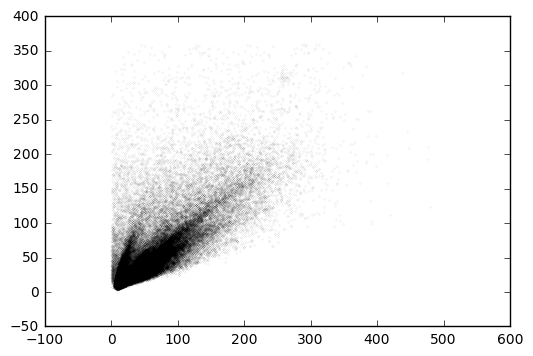

In [53]:

import matplotlib.pyplot as plt
%matplotlib inline 

plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')

In [59]:
'''
Created on Feb 20, 2017

@author: jumabek
'''
from os import listdir
from os.path import isfile, join
import argparse
import cv2
import numpy as np
import sys
import os
import shutil
import random 
import math
import json

width_in_cfg_file = 416.
height_in_cfg_file = 416.

def IOU(x,centroids):
    similarities = []
    k = len(centroids)
    for centroid in centroids:
        c_w,c_h = centroid
        w,h = x
        if c_w>=w and c_h>=h:
            similarity = w*h/(c_w*c_h)
        elif c_w>=w and c_h<=h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w<=w and c_h>=h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape
    return np.array(similarities) 

def avg_IOU(X,centroids):
    n,d = X.shape
    sum = 0.
    for i in range(X.shape[0]):
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(IOU(X[i],centroids)) 
    return sum/n

def write_anchors_to_file(centroids,X,anchor_file):
    f = open(anchor_file,'w')
    
    anchors = centroids.copy()
    print(anchors.shape)

    for i in range(anchors.shape[0]):
        anchors[i][0]*=width_in_cfg_file/32.
        anchors[i][1]*=height_in_cfg_file/32.
         

    widths = anchors[:,0]
    sorted_indices = np.argsort(widths)

    print('Anchors = ', anchors[sorted_indices])
        
    for i in sorted_indices[:-1]:
        f.write('%0.2f,%0.2f, '%(anchors[i,0],anchors[i,1]))

    #there should not be comma after last anchor, that's why
    f.write('%0.2f,%0.2f\n'%(anchors[sorted_indices[-1:],0],anchors[sorted_indices[-1:],1]))
    
    f.write('%f\n'%(avg_IOU(X,centroids)))

def kmeans(X,centroids,eps,anchor_file):
    
    N = X.shape[0]
    iterations = 0
    k,dim = centroids.shape
    prev_assignments = np.ones(N)*(-1)    
    iter = 0
    old_D = np.zeros((N,k))

    while True:
        D = [] 
        iter+=1           
        for i in range(N):
            d = 1 - IOU(X[i],centroids)
            D.append(d)
        D = np.array(D) # D.shape = (N,k)
        
        print ("iter {}: dists = {}".format(iter,np.sum(np.abs(old_D-D))))
            
        #assign samples to centroids 
        assignments = np.argmin(D,axis=1)
        
        #if (assignments == prev_assignments).all() :
        #    print("Centroids = ",centroids)            
        #    write_anchors_to_file(centroids,X,anchor_file)
        #    return

        if (assignments == prev_assignments).all() :
            print("Centroids = ",centroids)            
            return centroids
        
        #calculate new centroids
        centroid_sums=np.zeros((k,dim),np.float)
        for i in range(N):
            centroid_sums[assignments[i]]+=X[i]        
        for j in range(k):            
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j))
        
        prev_assignments = assignments.copy()     
        old_D = D.copy()  



In [60]:
num_clusters = 5
eps = 0.005
box_shape = np.array(box_shape)
anchor_file = 'anchors.txt'
indices = [ random.randrange(box_shape.shape[0]) for i in range(num_clusters)]
centroids = box_shape[indices] # randomly initialized the centroid to elements in the set
centroids = kmeans(box_shape,centroids,eps,anchor_file)

iter 1: dists = 369386.29910187534
iter 2: dists = 18636.652614317925
iter 3: dists = 4475.195712722198
iter 4: dists = 3134.6959189705194
iter 5: dists = 2312.476739263041
iter 6: dists = 1579.6821738848846
iter 7: dists = 1175.8829553650153
iter 8: dists = 870.3235842510056
iter 9: dists = 659.7582568323921
iter 10: dists = 501.3422477089435
iter 11: dists = 426.7916526092254
iter 12: dists = 339.00159364858683
iter 13: dists = 256.99248065531975
iter 14: dists = 221.83320850498197
iter 15: dists = 184.91238178798991
iter 16: dists = 202.57389662992603
iter 17: dists = 213.16362427411084
iter 18: dists = 213.97013382421582
iter 19: dists = 223.118778310941
iter 20: dists = 204.76022274168952
iter 21: dists = 184.43109154240068
iter 22: dists = 170.62517015602464
iter 23: dists = 166.10377116838816
iter 24: dists = 139.10973975352675
iter 25: dists = 100.60604952761673
iter 26: dists = 100.29100072746436
iter 27: dists = 63.155859470375454
iter 28: dists = 67.36619228765707
iter 29: d

In [86]:
# For 416x416 images anchor box should be between [0 to 13], because 416/32 = 13
img_width = 480
img_height = 480
width_in_cfg_file = 416
anchors_run1 = np.array([[ 84.11859391, 62.48059889],
 [ 45.85978864,  41.8359212 ],
 [209.33544883, 181.98939407],
 [ 20.22370778,  22.44749422],
 [119.03518113, 119.03729681]])
for i in range(anchors_run1.shape[0]):
    anchors_run1[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run1[i][1]*=width_in_cfg_file/480.
    anchors_run1[i][0]/=32. 
    anchors_run1[i][1]/=32.
print(anchors_run1)    

[[2.27821192 1.69218289]
 [1.24203594 1.1330562 ]
 [5.66950174 4.92887942]
 [0.54772542 0.60795297]
 [3.22386949 3.22392679]]


In [85]:
anchors_run2 = np.array([[136.51134673, 111.27001078],
 [ 78.669171,    75.00685743],
 [ 47.89625292, 38.61094355],
 [ 20.05567117,  22.84915965],
 [204.05708251, 191.71262056]])
for i in range(anchors_run1.shape[0]):
    anchors_run2[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run2[i][1]*=width_in_cfg_file/480.
    anchors_run2[i][0]/=32. 
    anchors_run2[i][1]/=32.
print(anchors_run2)   


[[3.69718231 3.01356279]
 [2.13062338 2.03143572]
 [1.29719018 1.04571305]
 [0.54317443 0.61883141]
 [5.52654598 5.19221681]]


In [66]:
a = [[12,2],[2,3]]